## Applied Data Science Capstone - Week 5

## Data Source:
1st: Scrap list of postal codes on Wikipedia page
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 

In [1]:
#Import pandas library
import pandas as pd

In [2]:
#Define website to be scrapped
W='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
#Use .read_html method to scrap ALL tables in the website
dfs = pd.read_html(W, header=0)

In [4]:
#Desired table will be the 1st in the resulted list, i.e. [0]
#Display dataframe
dfs[0]

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [5]:
#Check variables in Borough column
dfs[0]['Borough'].value_counts(dropna= False)

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [6]:
#Make a new dataframe df
df = dfs[0][dfs[0]['Borough'] != 'Not assigned'] #Select rows where Borough is NOT "Not assigned"
df

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [7]:
#Tidy up the dataframe
df = df.reset_index(drop = True) #Reset index starting from 0

In [8]:
#Tidy up the dataframe
df = df.rename(columns = {'Neighbourhood': 'Neighborhood'}) #Rename column Neighborhood
df.head(5)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


2nd: Extract Geographical data given by IBM at “Applied Data Science Capstone” course
http://cocl.us/Geospatial_data 

In [9]:
#Get geographical coordinates of each postal code; in CSV file
df1 = pd.read_csv('http://cocl.us/Geospatial_data')
df1

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [10]:
#Merge 2 dataframes anchoring 'Postal Code'
#Use how='inner' so as to get Postal Code which are present in both df and df1
df2 = pd.merge(df, df1, how='inner', on='Postal Code')
df2.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


3rd: Get latest geo-data from various libraries, including:
* Geopy: to get the latitude and longitude values of Toronto
* Folium: to Create a map of Toronto with neighborhoods superimposed on top for visualization analysis
* Foursquare API: to get location data, i.e. name of venues, respective categories, neighborhood, location coordinates for later analysis

And generate maps to visualize the neighborhoods

In [11]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests

#Import needed libraries
import numpy as np # library to handle data in a vectorized manner
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


Use geopy library to get the latitude and longitude values of Toronto.

In [12]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


To simplify the analysis, we will emphasize the key and downtown areas in Toronto. Therefore, we will screen boroughs with Toronto. Namely, these key boroughs are:
* Downtown Toronto
* East Toronto
* West Toronto
* Central Toronto

In [13]:
#Make a new dataframe for analysis
neighborhoods = df2[df2['Borough'].str.contains("Toronto")] #Focus on borough which contains Toronto
neighborhoods['Borough'].value_counts(dropna= False).to_frame()

,Borough
Downtown Toronto,19
Central Toronto,9
West Toronto,6
East Toronto,5


In [14]:
#Edit dataframe for analysis
neighborhoods = neighborhoods.reset_index(drop=True) #Reset index starting from 0
neighborhoods.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Use Folium and create a map of Toronto with neighborhoods superimposed on top.

In [15]:
#Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

#Add neighborhoods' markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Use Foursquare and define its Credentials and Version

In [41]:
CLIENT_ID = 'DUMMY' # your Foursquare ID
CLIENT_SECRET = 'DUMMY' # your Foursquare Secret
VERSION = '20201212' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DUMMY
CLIENT_SECRET:DUMMY


Explore the first neighborhood (N0) in the dataframe.


In [17]:
#Get 1st neighbor in the dataframe
N0 = neighborhoods.loc[0, 'Neighborhood']
print(N0)

Regent Park, Harbourfront


In [18]:
#Get the neighborhood's latitude and longitude values
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


Get the top 100 venues that are in first neighborhood (N0) within a radius of 500 meters.


In [42]:
#Create the GET request URL; name it url
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=DUMMY&client_secret=DUMMY&v=20201212&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [20]:
#Send the GET request and examine the resutls
results = requests.get(url).json()
#results

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


## 3. Methodology

### Explore neighborhoods in a part of Toronto City

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                       latitudes=neighborhoods['Latitude'],
                                       longitudes=neighborhoods['Longitude'])
neighborhoods_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
...,...,...,...,...,...,...,...
1619,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1620,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1621,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1622,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


Add Borough back to data

In [26]:
neighborhoods_venues['Venue Category'].value_counts(dropna= False).to_frame()

,Venue Category
Coffee Shop,158
Café,84
Restaurant,56
Hotel,41
Italian Restaurant,37
...,...
Malay Restaurant,1
Airport Terminal,1
Coworking Space,1
College Gym,1


In [27]:
print('Before selection, there are', len(neighborhoods_venues['Venue Category'].unique()), 'unique venue categories.')

Before selection, there are 235 unique venue categories.


At first glances, we can see the location cover a very wide spectrum of venues and categories, include restaurants and café. In order to focus on “Sports & Fitness Service”, we will focus to look at related categories. They include:
* Athletics & Sports
* Climbing Gym
* College Gym
* Dance Studio
* Gym
* Gym / Fitness Center
* Martial Arts School
* Sports Bar
* Swim School
* Yoga Studio

In [28]:
neighborhoods_sportsvenues = neighborhoods_venues[neighborhoods_venues['Venue Category'].str.contains('Gym|Sports|Dance|Fit|Martial|Swim|Yoga')] #Focus on venue category which contains gym
neighborhoods_sportsvenues = neighborhoods_sportsvenues.reset_index(drop=True)
neighborhoods_sportsvenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
1,"Regent Park, Harbourfront",43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Hart House Gym,43.664172,-79.394888,Gym
4,"Garden District, Ryerson",43.657162,-79.378937,Hard Candy Fitness,43.659556,-79.382440,Gym / Fitness Center


Remarks: For data analysis in the later stage, let’s insert back the column “Borough” into the dataset.

In [29]:
neighborhoods_sportsvenues = pd.merge(neighborhoods_sportsvenues, df, how='left', on='Neighborhood')
neighborhoods_sportsvenues = neighborhoods_sportsvenues.drop(['Postal Code'], axis= 1)
neighborhoods_sportsvenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center,Downtown Toronto
1,"Regent Park, Harbourfront",43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio,Downtown Toronto
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio,Downtown Toronto
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Hart House Gym,43.664172,-79.394888,Gym,Downtown Toronto
4,"Garden District, Ryerson",43.657162,-79.378937,Hard Candy Fitness,43.659556,-79.382440,Gym / Fitness Center,Downtown Toronto


Now, we are about to map all Sports & Fitness venues on Toronto.

In [30]:
#Create map of Toronto using latitude and longitude values
map_toronto_sportsvenues = folium.Map(location=[latitude, longitude], zoom_start=12)

#Add sports venues' markers to map
for lat, lng, venue, category, neighborhood in zip(neighborhoods_sportsvenues['Venue Latitude'],
                                                   neighborhoods_sportsvenues['Venue Longitude'],
                                                   neighborhoods_sportsvenues['Venue'],
                                                   neighborhoods_sportsvenues['Venue Category'],
                                                   neighborhoods_sportsvenues['Neighborhood']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_sportsvenues)  
    
map_toronto_sportsvenues

Display number and distribution of Sports & Fitness venues

In [31]:
neighborhoods_sportsvenues['Venue Category'].value_counts(dropna= False).to_frame()

,Venue Category
Gym,26
Yoga Studio,12
Gym / Fitness Center,10
Dance Studio,3
Martial Arts School,1
Athletics & Sports,1
College Gym,1
Sports Bar,1
Swim School,1
Climbing Gym,1


Visualize distribution of Sports & Fitness venues on a bar plot

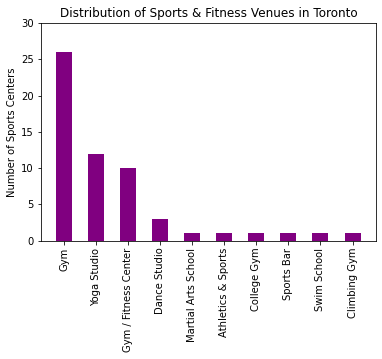

In [32]:
N = len(neighborhoods_sportsvenues['Venue Category'].value_counts(dropna= False).tolist())
x = neighborhoods_sportsvenues['Venue Category'].value_counts(dropna= False).tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

X = plt.bar(ind, x, width, color='purple')

plt.title('Distribution of Sports & Fitness Venues in Toronto')

plt.ylabel('Number of Sports Centers')
plt.yticks(np.arange(0, 31, 5))

plt.xticks(ind, neighborhoods_sportsvenues['Venue Category'].value_counts(dropna= False).to_frame().index.tolist(),rotation=90)

plt.show()

#### 4. Results

Now, we have a clearer picture of distribution of "Sports & Fitness" centres in Toronto. To make the data more readable, we will group all below categories (with minor occurence) into  a broader groups: 'Other Sports Center':
* Dance Studio
* Martial Arts School
* College Gym
* Sports Bar
* Athletics & Sports
* Climbing Gym
* Swim School

In [33]:
#Group Dance Studio and other centres into "Other Specialty Center"
neighborhoods_sportsvenues['Venue Re-Cat'] = neighborhoods_sportsvenues['Venue Category']
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Dance Studio','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Martial Arts School','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Climbing Gym','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Athletics & Sports','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Sports Bar','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('College Gym','Other Sports Center',inplace=True)
neighborhoods_sportsvenues['Venue Re-Cat'].replace('Swim School','Other Sports Center',inplace=True)
neighborhoods_sportsvenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Venue Re-Cat
0,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center,Downtown Toronto,Gym / Fitness Center
1,"Regent Park, Harbourfront",43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio,Downtown Toronto,Yoga Studio
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio,Downtown Toronto,Yoga Studio
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Hart House Gym,43.664172,-79.394888,Gym,Downtown Toronto,Gym
4,"Garden District, Ryerson",43.657162,-79.378937,Hard Candy Fitness,43.659556,-79.382440,Gym / Fitness Center,Downtown Toronto,Gym / Fitness Center


Display number and distribution of Sports & Fitness venues

In [34]:
neighborhoods_sportsvenues['Venue Re-Cat'].value_counts(dropna= False).to_frame()

,Venue Re-Cat
Gym,26
Yoga Studio,12
Gym / Fitness Center,10
Other Sports Center,9


Visualize distribution of Sports & Fitness venues on a bar plot

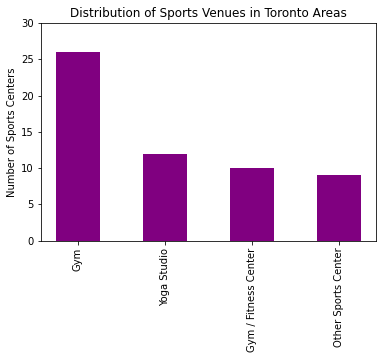

In [35]:
N = len(neighborhoods_sportsvenues['Venue Re-Cat'].value_counts(dropna= False).tolist())
x = neighborhoods_sportsvenues['Venue Re-Cat'].value_counts(dropna= False).tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

X = plt.bar(ind, x, width, color='purple')

plt.title('Distribution of Sports Venues in Toronto Areas')

plt.ylabel('Number of Sports Centers')
plt.yticks(np.arange(0, 31, 5))

plt.xticks(ind, neighborhoods_sportsvenues['Venue Re-Cat'].value_counts(dropna= False).to_frame().index.tolist(),rotation=90)

plt.show()

Then, we shall dissent number and distribution of "Sports & Fitness" centres by key borough in Toronto

In [36]:
neighborhoods_sportsvenues['Borough'].value_counts(dropna= False).to_frame()

,Borough
Downtown Toronto,41
Central Toronto,6
East Toronto,5
West Toronto,5


Next, we use pivot table to read data by borough

In [37]:
neighborhoods_sportsvenues_dis = neighborhoods_sportsvenues.pivot_table(index='Venue Re-Cat',
                                                                        columns='Borough',
                                                                        values='Venue', aggfunc='count')
neighborhoods_sportsvenues_dis= neighborhoods_sportsvenues_dis.replace(np.NaN,0)
neighborhoods_sportsvenues_dis

Borough,Central Toronto,Downtown Toronto,East Toronto,West Toronto
Venue Re-Cat,,,,
Gym,2.0,21.0,1.0,2.0
Gym / Fitness Center,1.0,7.0,2.0,0.0
Other Sports Center,2.0,6.0,0.0,1.0
Yoga Studio,1.0,7.0,2.0,2.0


Altogether, we can make a few observations already:
* Downtown Toronto accomodates the majority of "Sports & Fitness", 41. It is more than total number of "Sports & Fitness" in 3 other key ares combined
* "Gym" is the most common type of "Sports & Fitness" whereas they are most often in Downtown.
* Compared to "Gym", all other types of "Sports & Fitness" is much less common in all other areas.
* There are no other sports center in East Toronto. Also, gym/ fitness are absent in West Toronto.

In [38]:
neighborhoods_sportsvenues_dis.transpose()

Venue Re-Cat,Gym,Gym / Fitness Center,Other Sports Center,Yoga Studio
Borough,,,,
Central Toronto,2.0,1.0,2.0,1.0
Downtown Toronto,21.0,7.0,6.0,7.0
East Toronto,1.0,2.0,0.0,2.0
West Toronto,2.0,0.0,1.0,2.0


#### 5. Results

Visualize distribution of Sports & Fitness venues in different Borough on a bar plot

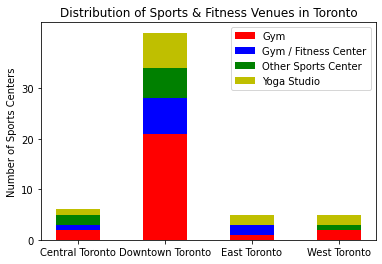

In [39]:
N = len(neighborhoods_sportsvenues_dis.columns.tolist())
TC0 = neighborhoods_sportsvenues_dis.transpose()['Gym'].tolist()
TC1 = neighborhoods_sportsvenues_dis.transpose()['Gym / Fitness Center'].tolist()
TC2 = neighborhoods_sportsvenues_dis.transpose()['Other Sports Center'].tolist()
TC3 = neighborhoods_sportsvenues_dis.transpose()['Yoga Studio'].tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, TC0, width, color='r')
p2 = plt.bar(ind, TC1, width, bottom=np.array(TC0), color='b')
p3 = plt.bar(ind, TC2, width, bottom=np.array(TC0)+np.array(TC1), color='g')
p4 = plt.bar(ind, TC3, width, bottom=np.array(TC0)+np.array(TC1)+np.array(TC2), color='y')

plt.title('Distribution of Sports & Fitness Venues in Toronto')

plt.ylabel('Number of Sports Centers')
plt.yticks(np.arange(0, 31, 10))

plt.xticks(ind, neighborhoods_sportsvenues_dis.columns.tolist())

plt.legend((p1[0], p2[0], p3[0], p4[0]), neighborhoods_sportsvenues_dis.transpose().columns.tolist())

plt.show()

Map all Sports & Fitness venues by different colors on Toronto
* Gym (red)
* Gym / Fitness Center (blue)
* Other Sports Center (green)
* Yoga Studio (yellow)

In [40]:
#Create map of Toronto using latitude and longitude values
map_toronto_sportsvenues_c = folium.Map(location=[latitude, longitude], zoom_start=12)

#Add sports venue markers to map - Gym (Red)
N_TC = neighborhoods_sportsvenues[neighborhoods_sportsvenues['Venue Re-Cat']=='Gym']
for lat, lng, venue, category, neighborhood in zip(N_TC['Venue Latitude'],
                                                   N_TC['Venue Longitude'],
                                                   N_TC['Venue'],
                                                   N_TC['Venue Re-Cat'],
                                                   N_TC['Neighborhood']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=4, popup=label, fill=True, fill_color='#3186cc', fill_opacity=0.7,
                        color = 'red',
                        parse_html=False).add_to(map_toronto_sportsvenues_c)  

#Add sports venue markers to map - Yoga Studio (Blue)
N_TC = neighborhoods_sportsvenues[neighborhoods_sportsvenues['Venue Re-Cat']=='Yoga Studio']
for lat, lng, venue, category, neighborhood in zip(N_TC['Venue Latitude'],
                                                   N_TC['Venue Longitude'],
                                                   N_TC['Venue'],
                                                   N_TC['Venue Re-Cat'],
                                                   N_TC['Neighborhood']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=4, popup=label, fill=True, fill_color='#3186cc', fill_opacity=0.7,
                        color = 'blue',
                        parse_html=False).add_to(map_toronto_sportsvenues_c)  

#Add sports venue markers to map - Gym / Fitness Center (Green)
N_TC = neighborhoods_sportsvenues[neighborhoods_sportsvenues['Venue Re-Cat']=='Gym / Fitness Center']
for lat, lng, venue, category, neighborhood in zip(N_TC['Venue Latitude'],
                                                   N_TC['Venue Longitude'],
                                                   N_TC['Venue'],
                                                   N_TC['Venue Re-Cat'],
                                                   N_TC['Neighborhood']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=4, popup=label, fill=True, fill_color='#3186cc', fill_opacity=0.7,
                        color = 'green',
                        parse_html=False).add_to(map_toronto_sportsvenues_c)  
    
#Add sports venue markers to map - Other Sports Center (Yellow)
N_TC = neighborhoods_sportsvenues[neighborhoods_sportsvenues['Venue Re-Cat']=='Other Sports Center']
for lat, lng, venue, category, neighborhood in zip(N_TC['Venue Latitude'],
                                                   N_TC['Venue Longitude'],
                                                   N_TC['Venue'],
                                                   N_TC['Venue Re-Cat'],
                                                   N_TC['Neighborhood']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=4, popup=label, fill=True, fill_color='#3186cc', fill_opacity=0.7,
                        color = 'yellow',
                        parse_html=False).add_to(map_toronto_sportsvenues_c)  

map_toronto_sportsvenues_c

#### 5. Discussion

By now, we have gathered sufficient information to answer the business objectives.

Areas with the most and least sports service centres:

Downtown Toronto is, obviously, the areas most concentrated with “Sports & Fitness” venues. Other areas (namely, East, West and Central) contain just a few venues.

Also, these sport venues are heavily skewed towards “Gym”, distantly followed by “Yoga Studio” and “Fitness”. Other specialty (e.g. Martials Arts, Climbing) are lacking.

Discover potentials for provision of “Sports & Fitness Services”:
* From the map, we see a lot of “Sports & Fitness” venues are concentrated in city center, “Downtown”. The peripheral of city areas are less concentrated. As competition in Downtown areas is getting more and more fierce, it is time to consider put new “Sports and Fitness” venues in other areas where competition is still low.
* We have an impression that specialty centers (e.g. “Yoga Studio” and “Fitness”) have potential, given there are just very few in the city currently. As consumers are more aware of these sports centers, they are likely to have higher demand of such centers. Service providers are advised to plan setting up these centres in the future and gather capital for the future.

#### 6. Conclusion

Like we what have set up in background, “Sports & Fitness” industry become very important to consumers nowadays. It is not just limited to a niche portion of elite citizens but all residents in general. In this analysis, we identify a few potentials for consideration for service providers, for example:
* What types of “Sports & Fitness” venues are missing / lagging behind in quantity?
* How are “Sports & Fitness” venues distributed in Toronto?

These are important information for service providers. However, given the ever-changing situation in Toronto, it is vital to keep monitoring the latest data. Therefore, data analysis become the best tool in this exercise, as we re-run the analysis with the same codes and execution in regular time interval without much hassles. We would recommend service providers to continuously keep track of changing distribution of “Sports & Fitness” (e.g. every quarter) in the coming future.